## Loading the cifar 10 dataset

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from IPython import display
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os
import cifar10

cifar10.maybe_download_and_extract()
images_train, cls_train, labels_train = cifar10.load_training_data()


Data has apparently already been downloaded and unpacked.
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5


## Checking the dimension of the dataset
<html> <h3>Here I am using only 50000 examples to train the GAN
Also loading the labels, to plot the images for checking if the correct images are loaded</h3></html>

In [4]:
print(images_train.shape)
class_names = cifar10.load_class_names()
print(class_names)

(50000, 32, 32, 3)
Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Function used to plot the images for checking

In [5]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 9

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)
            
        # Name of the true class.
        cls_true_name = class_names[cls_true[i]]

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

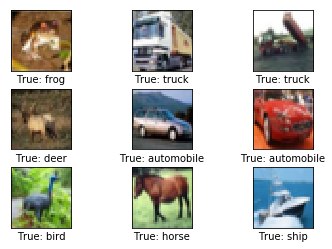

In [6]:
# Get the first images from the test-set.
images = images_train[0:9]

# Get the true classes for those images.
cls_true = cls_train[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=False)

## Not sure what this does, figuring it out now

In [5]:
# Code by Parag Mital (https://github.com/pkmital/CADL/)
def montage(images):    
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    if len(images.shape) == 4 and images.shape[3] == 3:
        m = np.ones(
            (images.shape[1] * n_plots + n_plots + 1,
             images.shape[2] * n_plots + n_plots + 1, 3)) * 0.5
    elif len(images.shape) == 4 and images.shape[3] == 1:
        m = np.ones(
            (images.shape[1] * n_plots + n_plots + 1,
             images.shape[2] * n_plots + n_plots + 1, 1)) * 0.5
    elif len(images.shape) == 3:
        m = np.ones(
            (images.shape[1] * n_plots + n_plots + 1,
             images.shape[2] * n_plots + n_plots + 1)) * 0.5
    else:
        raise ValueError('Could not parse image shape of {}'.format(
            images.shape))
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                m[1 + i + i * img_h:1 + i + (i + 1) * img_h,
                  1 + j + j * img_w:1 + j + (j + 1) * img_w] = this_img
    return m

<html><h1> The procedure</h1><p> The data is divided into batched of 100 examples, the noise also has a dimension of 100*100</p><p><h2> Discriminator </h2> The discriminator takes the input , reshapes it to a  32*32*3 array and applies layers of convolution and dropout, similarly the generator also performs the reverse operation.</p></html> 

In [6]:
tf.reset_default_graph()
batch_size = 100
n_noise = 100

X_in = tf.placeholder(dtype=tf.float32, shape=[None, 32, 32, 3], name='X')
noise = tf.placeholder(dtype=tf.float32, shape=[None, n_noise])

keep_prob = tf.placeholder(dtype=tf.float32, name='keep_prob')
is_training = tf.placeholder(dtype=tf.bool, name='is_training')

def lrelu(x):
    return tf.maximum(x, tf.multiply(x, 0.2))

def binary_cross_entropy(x, z):
    eps = 1e-12
    return (-(x * tf.log(z + eps) + (1. - x) * tf.log(1. - z + eps)))

def discriminator(img_in, reuse=None, keep_prob=keep_prob):
    activation = lrelu
    with tf.variable_scope("discriminator", reuse=reuse):
        x = tf.reshape(img_in, shape=[-1, 32, 32, 3])
        print("X inside discriminator 1. ",x.get_shape,"\n")
        x = tf.layers.conv2d(x, kernel_size=5, filters=256, strides=2, padding='same', activation=activation)
        print("X inside discriminator 2. ",x.get_shape,"\n")
        x = tf.layers.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, kernel_size=5, filters=128, strides=1, padding='same', activation=activation)
        print("X inside discriminator 3. ",x.get_shape,"\n")
        x = tf.layers.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, kernel_size=5, filters=64, strides=1, padding='same', activation=activation)
        print("X inside discriminator 4. ",x.get_shape,"\n")
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=128, activation=activation)
        x = tf.layers.dense(x, units=1, activation=tf.nn.sigmoid)
        print("LAST SHAPE of x inside the discriminator",x.get_shape,"\n")
        return x
    
def generator(z, keep_prob=keep_prob, is_training=is_training):
    activation = lrelu
    momentum = 0.9
    with tf.variable_scope("generator", reuse=None):
        x = z
        
        d1 = 4#3
        d2 = 3
        
        x = tf.layers.dense(x, units=d1 * d1 * d2, activation=activation)
        x = tf.layers.dropout(x, keep_prob)      
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)  
        
        x = tf.reshape(x, shape=[-1, d1, d1, d2])
        x = tf.image.resize_images(x, size=[8, 8])
        print("X inside generator 1.",x.get_shape,"\n")
        
        
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=256, strides=2, padding='same', activation=activation)
        print("X inside generator 2.",x.get_shape,"\n")
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=128, strides=2, padding='same', activation=activation)
        print("X inside generator 3.",x.get_shape,"\n")
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=64, strides=1, padding='same', activation=activation)
        print("X inside generator 4.",x.get_shape,"\n")
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=3, strides=1, padding='same', activation=tf.nn.sigmoid)
        print("X inside generator 5.",x.get_shape,"\n")
        print("LAST SHAPE of x inside the generator",x.get_shape,"\n")
        return x    

In [7]:
g = generator(noise, keep_prob, is_training)
d_real = discriminator(X_in)
d_fake = discriminator(g, reuse=True)

vars_g = [var for var in tf.trainable_variables() if var.name.startswith("generator")]
vars_d = [var for var in tf.trainable_variables() if var.name.startswith("discriminator")]


d_reg = tf.contrib.layers.apply_regularization(tf.contrib.layers.l2_regularizer(1e-6), vars_d)
g_reg = tf.contrib.layers.apply_regularization(tf.contrib.layers.l2_regularizer(1e-6), vars_g)

loss_d_real = binary_cross_entropy(tf.ones_like(d_real), d_real)
loss_d_fake = binary_cross_entropy(tf.zeros_like(d_fake), d_fake)
loss_g = tf.reduce_mean(binary_cross_entropy(tf.ones_like(d_fake), d_fake))

loss_d = tf.reduce_mean(0.5 * (loss_d_real + loss_d_fake))

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer_d = tf.train.RMSPropOptimizer(learning_rate=0.0001).minimize(loss_d + d_reg, var_list=vars_d)
    optimizer_g = tf.train.RMSPropOptimizer(learning_rate=0.0002).minimize(loss_g + g_reg, var_list=vars_g)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

X inside generator 1. <bound method Tensor.get_shape of <tf.Tensor 'generator/resize_images/ResizeBilinear:0' shape=(?, 8, 8, 3) dtype=float32>> 

X inside generator 2. <bound method Tensor.get_shape of <tf.Tensor 'generator/conv2d_transpose/Maximum:0' shape=(?, 16, 16, 256) dtype=float32>> 

X inside generator 3. <bound method Tensor.get_shape of <tf.Tensor 'generator/conv2d_transpose_1/Maximum:0' shape=(?, 32, 32, 128) dtype=float32>> 

X inside generator 4. <bound method Tensor.get_shape of <tf.Tensor 'generator/conv2d_transpose_2/Maximum:0' shape=(?, 32, 32, 64) dtype=float32>> 

X inside generator 5. <bound method Tensor.get_shape of <tf.Tensor 'generator/conv2d_transpose_3/Sigmoid:0' shape=(?, 32, 32, 3) dtype=float32>> 

LAST SHAPE of x inside the generator <bound method Tensor.get_shape of <tf.Tensor 'generator/conv2d_transpose_3/Sigmoid:0' shape=(?, 32, 32, 3) dtype=float32>> 

X inside discriminator 1.  <bound method Tensor.get_shape of <tf.Tensor 'discriminator/Reshape:0' sh

0 0.691352 0.720616


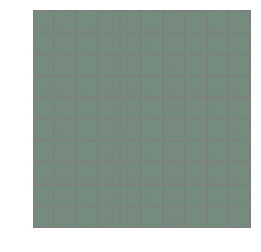

1000 0.706836 0.827654


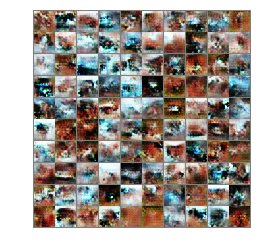

2000 0.686998 0.827924


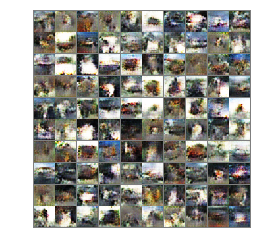

3000 0.652098 0.763895


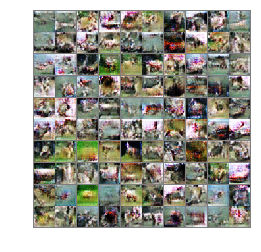

4000 0.685557 0.796963


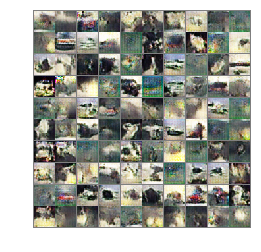

5000 0.668879 1.00709
not training discriminator


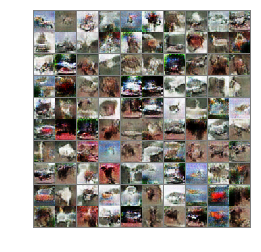

6000 0.736082 0.51371
not training generator


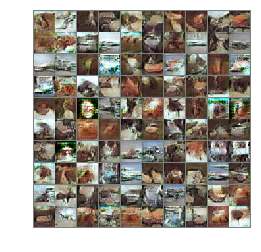

7000 0.657589 0.810878


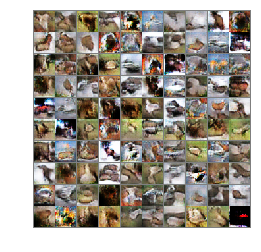

8000 0.631641 0.999822
not training discriminator


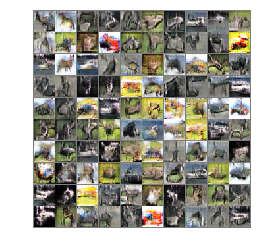

9000 0.663383 0.878477


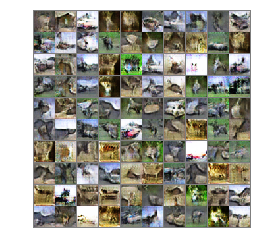

10000 0.653901 0.834333


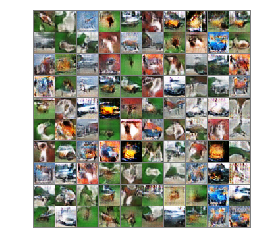

11000 0.691212 0.937581
not training discriminator


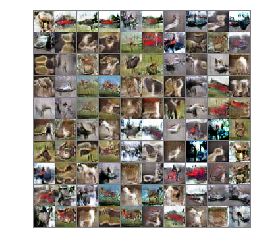

12000 0.609023 0.730024


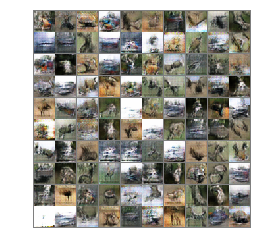

13000 0.68285 0.982271
not training discriminator


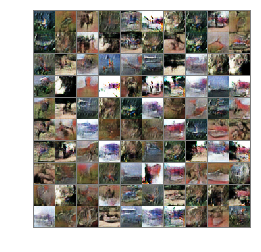

14000 0.655397 0.825645


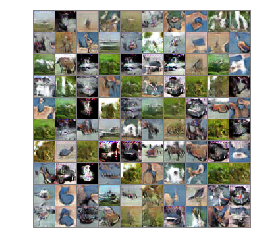

15000 0.64168 0.99716
not training discriminator


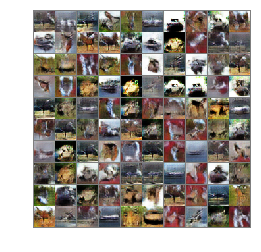

16000 0.671688 1.03529
not training discriminator


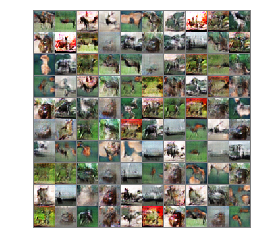

17000 0.731324 0.953623


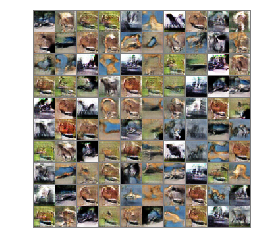

18000 0.625693 0.802517


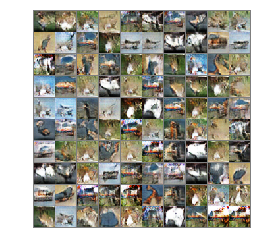

19000 0.767203 1.0289


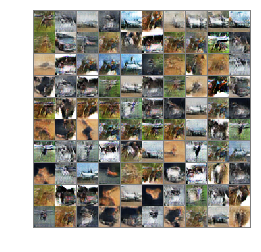

20000 0.714415 0.95509


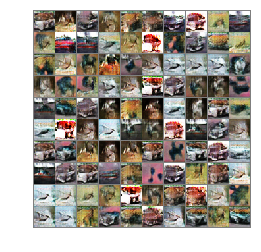

21000 0.671983 1.01232
not training discriminator


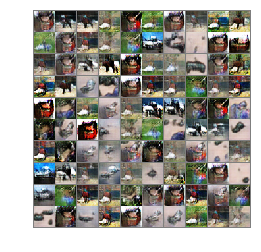

22000 0.686936 0.963069
not training discriminator


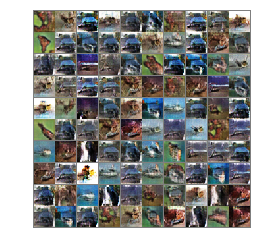

23000 0.763618 1.124
not training discriminator


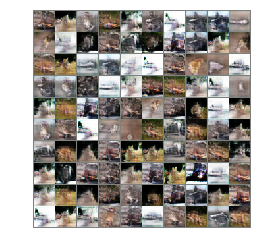

24000 0.780403 1.11987
not training discriminator


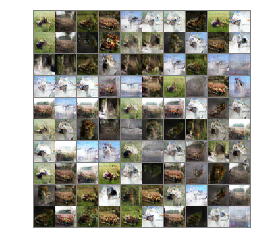

25000 0.709122 0.902207


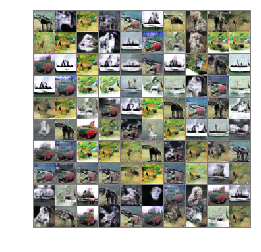

26000 0.645903 0.817897


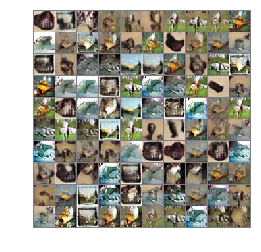

27000 0.662171 0.909208
not training discriminator


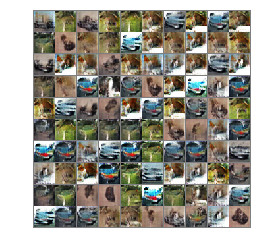

28000 0.625665 0.667465


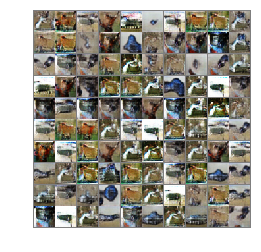

29000 0.647357 0.703709


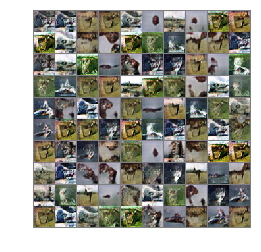

30000 0.751456 1.00892


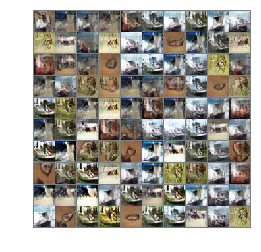

31000 0.631541 0.92834
not training discriminator


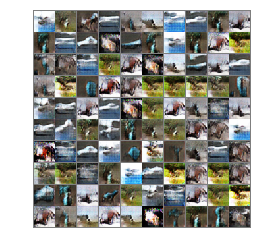

32000 0.658109 0.924529
not training discriminator


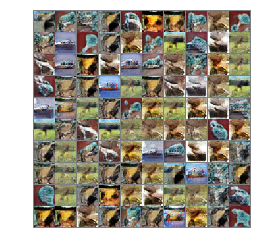

33000 0.653492 0.98025
not training discriminator


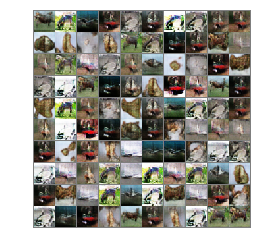

34000 0.640184 0.876718
not training discriminator


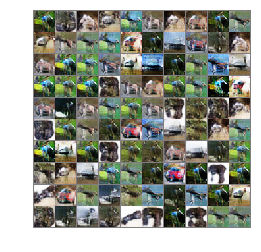

35000 0.762814 1.65226
not training discriminator


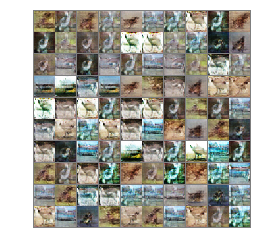

36000 0.616592 0.690085


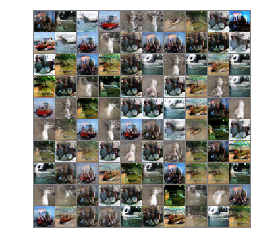

37000 0.725384 1.11176
not training discriminator


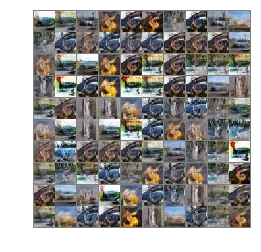

38000 0.565949 0.874217
not training discriminator


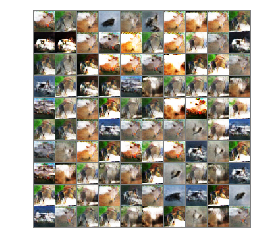

In [ ]:
current_index = 0
for i in range(60000):
    train_d = True
    train_g = True
    keep_prob_train = 0.6 # 0.5
    
    #batch_size = 64, n_noise = 64
    n = np.random.uniform(0.0, 1.0, [batch_size, n_noise]).astype(np.float32)   
    X_batch=images_train[current_index:current_index+batch_size]
    if(current_index==49900):
        current_index=0
    else:
        current_index=current_index+batch_size
    
    d_real_ls, d_fake_ls, g_ls, d_ls = sess.run([loss_d_real, loss_d_fake, loss_g, loss_d], feed_dict={X_in: X_batch, noise: n, keep_prob: keep_prob_train, is_training:True})
    
    d_fake_ls_init = d_fake_ls
    
    d_real_ls = np.mean(d_real_ls)
    d_fake_ls = np.mean(d_fake_ls)
    g_ls = g_ls
    d_ls = d_ls
        
    if g_ls * 1.35 < d_ls:
        train_g = False
        pass
    if d_ls * 1.35 < g_ls:
        train_d = False
        pass
    
    if train_d:
        sess.run(optimizer_d, feed_dict={noise: n, X_in: X_batch, keep_prob: keep_prob_train, is_training:True})
        
        
    if train_g:
        sess.run(optimizer_g, feed_dict={noise: n, keep_prob: keep_prob_train, is_training:True})
        
        
    if not i % 1000:
        display.clear_output(True)
        print (i, d_ls, g_ls)
        if not train_g:
            print("not training generator")
        if not train_d:
            print("not training discriminator")
        gen_imgs = sess.run(g, feed_dict = {noise: n, keep_prob: 1.0, is_training:False})
        imgs = [img[:,:,:] for img in gen_imgs]
        m = montage(imgs)
        #m = imgs[0]
        plt.axis('off')
        plt.imshow(m, cmap='gray')
        plt.show()